# PA3

## Dataset

For this assignment, our data comes from about 4.5 thousand inpatient rehabilitation patients. The attributes for each instance are as follows:

* ID *(integer)*: Index of the dataset. Counting numbers starting at 0.
* Gender *(string)*: Gender of the patient, "M" for male and "F" for female.
* Age *(integer)*: Age of the patient in years
* Marital Status *(string)*: Description of the patient's marital status.
* RIC *(integer)*: RIC of the patient assigned according to [Appendix B in the Centers for Medicaid and Medicare Services IRF-PAI training manual.](https://www.cms.gov/medicare/medicare-fee-for-service-payment/inpatientrehabfacpps/downloads/irfpai-manual-2012.pd)
* Admission Total FIM Score *(integer)*: The admission total Functional Independence Measure (FIM) score of the patient.
    * The FIM is a clinical assessment used to measure patient functioning at inpatient rehabilitation hospitals. The FIM is measured at two distinct points in time: admission and discharge.
    * The FIM measures the level of assistance required to perform 18 ADL tasks.
    * The tasks are categorized as either motor (13 tasks) or cognitive (5 tasks). Each task is scored on a 7-point ordinal scale to measure independence as determined by the amount of assistance required to perform each ADL task.
    * For more information about the FIM, see Section III in the [Centers for Medicaid and Medicare Services IRF-PAI training manual.](https://www.cms.gov/medicare/medicare-fee-for-service-payment/inpatientrehabfacpps/downloads/irfpai-manual-2012.pdf)
* Discharge Total FIM Score *(integer)*: The discharge total FIM score of the patient.


*(Referenced from [PA3](https://github.com/GonzagaCPSC310/PAs/blob/master/PA3.ipynb))*

The first step is to pull the data from the Github repository it's hosted in. We do this with the following `get_text()` function, which will make a get request from the raw data URL and return the text.

Next, we need to put the data into a 2D list for easy manipulation. After pulling the raw text using `get_text()`, we will pass the result into the `create_dataset()` function which will:
1. Split the data by each instance based on new lines
2. Pop and store the first line of headers
3. Split each instance by its elements based on commas
4. Replace all numeric attributes with integers
5. Return the headers and the 2D array

In [1]:
import requests

def get_text(url):
    # code referenced from https://stackoverflow.com/questions/14120502/how-to-download-and-write-a-file-from-github-using-requests
    r = requests.get(url)
    text = r.text
    return text

def create_dataset(text):
    data_raw = text.split("\r\n")
    data_raw.pop()
    headers = data_raw.pop(0)
    for i in range(len(data_raw)):
        data_raw[i] = data_raw[i].split(",")
        if len(data_raw[i]) != 7:
            ms = data_raw[i][3] + data_raw[i][4]
            data_raw[i][3] = ms
            data_raw[i].pop(4)
    data = []
    for line in data_raw:
        instance = []
        for elem in line:
            try:
                instance.append(int(elem))
            except:
                instance.append(elem)
                
        data.append(instance)
    
    return headers, data


url = "https://raw.githubusercontent.com/GonzagaCPSC310/PAs/master/files/patient_data_to_clean.csv"
headers, data = create_dataset(get_text(url))

## Step 1: Cleaning

After creating the dataset, we need to clean certain attributes. For this dataset, we will be cleaining up Marital Status and RIC.

### Marital Status

The marital status attribute of the dataset does not enforce a strict coding system, and so while the majority of the data is well formed, there are many odd entries that don't make for clean classification. Since the physician entering the data could put anything for this field, there is no standard format, meaning that there are many spelling mistakes, capitalization or punctuation differences, and unique or odd entries. 

For our purposes, we would prefer this data to adhere to a strict coding system, so we will attempt to map each entry to one of 5 different marital statuses. These classifications are:
* Never Married
* Divorced
* Married
* Widowed
* Separated

In order to clean the data, we must first see what data is initially available. To do this, I first iterated through the dataset and put the marital status of each entry into a set. This ensures uniqueness, and allows me to see a shortened list of each different possible entry in the dataset without having to see all 4.5 thousand entries. I then restrict each entry to only ascii letters and cast each string into its lowercase form, which eliminates errors such as a trailing period or the difference between "married", "Married", and "mARRIED", all of which show up in the raw data. From here, entries are generally one of two categories: Typos, as in "marrired" instead of "married", or variations on a classification, such as "unmarried" or "single" for "never married."

To deal with typos, I've implemented several rules that cover each typo case in the generated set. These are rules such as strings containing "wid" are cast to "widowed", strings containing "marr" or "ried" but **not** containing "never" being cast to "married", etc.

Dealing with variations and unique entries was more difficult, and required rules that were more specific to the dataset. For example, I saw that the set contained "wife" and "so", meaning significant other. So, I cast these to "married". Or, in one case, an entry was of the form "d x 5 years", denoting that the patient was divorced for 5 years. In this case, I implemented the rule that if the first letter of the status is "d", it will be cast to "divorced". The trickiest of these was "never married", as there were several different ways physicians indicated this, including "single", "girlfriend", "engaged", "no", etc. Because of this, I implemented a catch-all rule as a base case, where if the given status is not cast based on one of the earlier rules, it is automatically determined to be "never married." While this could cause problems if the dataset is expanded, I tested the generated set with all the previous rules implemented and all of the remaining variances were different ways of indicating "never married", so in this case the explicit rules are enough that this base case does do what we want it to do. 

After generating the set again and seeing that all marital statuses were successfully cast to one of the 5 desired classifications, I eliminated the set creation and instead changed the attribute in each instance of the database to the correct classification based on the created rules set. This is all handled via the `clean_marital_status()` function, which will return the dataset after marital status has been cleaned.

In [2]:
from string import ascii_letters

def clean_marital_status(data):
    terms = {"married", "divorced", "widowed", "never married", "separated"}
    for instance in data:
        status = instance[3]
        # line referenced from https://stackoverflow.com/questions/1276764/stripping-everything-but-alphanumeric-chars-from-a-string-in-python
        status = "".join([ch for ch in status if ch in (ascii_letters + " ")])
        status = status.lower()
        
        # rules for cleaning marital status strings
        if status in terms:
            status = status
        elif "wid" in status:
            status = "widowed"
        elif "div" in status:
            status = "divorced"
        elif "sing" in status or "un" in status or "not" in status or "never" in status or "no" in status:
            status = "never married"
        elif "wife" in status or "husband" in status or "sig" in status or "so" in status:
            status = "married"
        elif ("marr" in status or "ried" in status) and ("never" not in status):
            status = "married"
        elif status[0] == "d":
            status = "divorced"

        else:
            status = "never married"
        
        instance[3] = status
    
    return data
        

    
data = clean_marital_status(data)

### RIC

Cleaning the RIC data is much easier than cleaning the marital status entries, since the raw data does adhere to a standard. For this attribute, we simply create a decoder dictionary *(Provided in [PA3](https://github.com/GonzagaCPSC310/PAs/blob/master/PA3.ipynb))* and use it to cast the integer values of the RIC attribute to a string representation. This is handled in `clean_RIC()`, which again returns the dataset after converting this data.

It is interesting to note that I originally decided to test this cleaning process with an `If` statement and printing out "Error" if it couldn't translate the RIC score to the decoded value. I expected to never get an "Error" printout, but to my surprise there were 5. Exploring further, I printed out the ID of each of these instances, as well as what their RIC was, and was very confused when each of the errored values was a string. Going back, I realized that when I split each instance into it's elements in `create_dataset()`, it was also splitting cases in which the Marital Status contained a comma, and so the problem wasn't that the RIC was entered improperly, but that the element at index 4 of the instance was the second part of the marital status attribute.

After going back and handling this case in the `create_dataset()` function, I reran the test and received no "Error" warnings, as expected.

In [3]:
def clean_RIC(data):
    # decoder referenced from PA3 Instructions
    ric_decoder = {1: "Stroke", 
                   2: "TBI", 
                   3: "NTBI", 
                   4: "TSCI", 
                   5: "NTSCI", 
                   6: "Neuro", 
                   7: "FracLE", 
                   8: "ReplLE", 
                   9: "Ortho", 
                   10: "AMPLE", 
                   11: "AMP-NLE", 
                   12: "OsteoA", 
                   13: "RheumA", 
                   14: "Cardiac", 
                   15: "Pulmonary", 
                   16: "Pain", 
                   17: "MMT-NBSCI", 
                   18: "MMT-BSCI", 
                   19: "GB", 
                   20: "Misc", 
                   21: "Burns"}
    for instance in data:
        ric = instance[4]
        ric_d = ric_decoder[ric]
        instance[4] = ric_d
    return data
            
data = clean_RIC(data)

After cleaning the data, we will write the dataset out to a file, "patient_data_cleaned.csv".

In [4]:
def write_data_to_csv(data, filename, headers=""):
    f = open(filename, "w")
    if headers != "":
        f.write(headers + "\n")
    for instance in data:
        instance_str = []
        for elem in instance:
            instance_str.append(str(elem))
        write_str = ",".join(instance_str)
        write_str += "\n"
        f.write(write_str)
    f.close()
    
write_data_to_csv(data, "patient_data_cleaned.csv", headers = headers)

## Step 2: Statistics

For this step, we will calculate several statistics of the dataset generated by Step 1. The statistics we will compute are as follows:

1. Total number of patients
2. Total number of males
3. Total number of females
4. Total number of married patients
5. RIC label for the most commonly occurring RIC
6. Total number of patients with the most commonly occurring RIC
7. Average age for stroke patients
8. Standard deviation of age for stroke patients
9. Average age for male stroke patients
10. Standard deviation of age for male stroke patients
11. Average age for female stroke patients
12. Standard deviation of age for female stroke patients

To do this, we will first construct several generalized helper functions. These functions are:

* `compute_total_instances()`  
    * **Params**: 
        * `data` = the dataset to query
    * **Returns**: The number of instances in that dataset
* `compute_attribute_frequency()`
    * **Params**: 
        * `data` = the dataset to query
        * `index` = the index of the attribute to query
        * `value` = the value to calculate the frequency for
    * **Returns**: Frequency of the given value for the given attribute in the dataset
* `compute_most_common_element()`
    * **Params**: 
        * `data` = the dataset to query
        * `index` = the index of the attribute to query
    * **Returns**: The most commonly occurring element of that attribute in the dataset
* `compute_dependent_statistics()`
    * **Params**:
        * `data` = the dataset to query
        * `stat_index` = the index of the attribute to calculate statistics for
        * `depend_indices` = list of indices for restricting attributes
        * `depend_values` = list of values for restricting attributes to match for
    * **Returns**: Average and Standard Deviation of the desired attribute for all instances whose restricting attributes match the given values

Additionally, the formulas we will use are as follows:

* **Average**: $\frac{\sum_{i=1}^{n} x}{n}$
* **Standard Deviation**: $\sqrt{\frac{\sum_{i=1}^{n} (x_{i} - \overline{x})^{2}}{n}}$

In [5]:
import operator
import numpy as np

def compute_total_instances(data):
    return len(data)

def compute_attribute_frequency(data, index, value):
    freq = 0
    for instance in data:
        if instance[index] == value:
            freq += 1
    return freq

def compute_most_common_element(data, index):
    freqs = {}
    for instance in data:
        if instance[index] in freqs:
            freqs[instance[index]] += 1
        else:
            freqs[instance[index]] = 1            
    # line referenced from https://stackoverflow.com/questions/268272/getting-key-with-maximum-value-in-dictionary
    mce = max(freqs.items(), key=operator.itemgetter(1))[0]
    return mce

def compute_dependent_statistics(data, stat_index, depend_indices, depend_values):
    values = []
    for instance in data:
        match_dependencies = True
        for i in range(len(depend_indices)):
            if instance[depend_indices[i]] != depend_values[i]:
                match_dependencies = False
        if match_dependencies == True:
            values.append(instance[stat_index])
    n = len(values)
    avg = sum(values) / n
    variances = []
    for x in values:
        variances.append((x - avg) ** 2)
    variance = sum(variances) / n
    std = np.sqrt(variance)
    return avg, std

Now that we have these helper functions defined, we can determine which function will be used for each desired statistic.

1. Total number of patients
    * `compute_total_instances()`
2. Total number of males
    * `compute_attribute_frequency()`
3. Total number of females
    * `compute_attribute_frequency()`
4. Total number of married patients
    * `compute_attribute_frequency()`
5. RIC label for the most commonly occurring RIC
    * `compute_most_common_element()`
6. Total number of patients with the most commonly occurring RIC
    * `compute_attribute_frequency()` *and* `compute_most_common_element()`
7. Average age for stroke patients
    * `compute_dependent_statistics()`
8. Standard deviation of age for stroke patients
    * `compute_dependent_statistics()`
9. Average age for male stroke patients
    * `compute_dependent_statistics()`
10. Standard deviation of age for male stroke patients
    * `compute_dependent_statistics()`
11. Average age for female stroke patients
    * `compute_dependent_statistics()`
12. Standard deviation of age for female stroke patients
    * `compute_dependent_statistics()`

In [6]:
statistics = []

statistics.append(["Total number of patients", compute_total_instances(data)])
statistics.append(["Total number of males", compute_attribute_frequency(data, 1, "M")])
statistics.append(["Total number of females", compute_attribute_frequency(data, 1, "F")])
statistics.append(["Total number of married patients", compute_attribute_frequency(data, 3, "married")])
statistics.append(["RIC label for the most commonly occurring RIC", compute_most_common_element(data, 4)])
statistics.append(["Total number of patients with the most commonly occurring RIC", compute_attribute_frequency(data, 4, compute_most_common_element(data, 4))])
avg7, std8 = compute_dependent_statistics(data, 2, [4], ["Stroke"])
statistics.append(["Average age for stroke patients", avg7])
statistics.append(["Standard deviation of age for stroke patients", std8])
avg9, std10 = compute_dependent_statistics(data, 2, [1, 4], ["M", "Stroke"])
statistics.append(["Average age for male stroke patients", avg9])
statistics.append(["Standard deviation of age for male stroke patients", std10])
avg11, std12 = compute_dependent_statistics(data, 2, [1, 4], ["F", "Stroke"])
statistics.append(["Average age for male stroke patients", avg11])
statistics.append(["Standard deviation of age for male stroke patients", std12])

Finally, we write the computed statistics into a file called "patient_data_stats.csv".

In [7]:
write_data_to_csv(statistics, "patient_data_stats.csv", headers="Statistic name, Value")

## Step 3: Visualization

We can now visualize our data in interesting ways. For this assignment, we will create scatter plots based on the RIC categories. For each category, we will plot each patient's Admission FIM score against their Discharge FIM score. We will split the data by gender, plotting Male and Female patients with blue dots and red crosses, respectively. 

Additionally, we will plot the line $y=x$ to represent no change. That is, patients on this line showed no change in their FIM score between admission and discharge. Subsequently, we can determine that any patients above this line showed improvement, while any patients below this line actually regressed during their stay. 

First, we will create a generalized helper function to create the plots. `generate_ric_chart()` takes the RIC value as a parameter and generates an in-line visualization of the data described.

In [30]:
import matplotlib.pyplot as plt

def generate_ric_chart(data, value):
    plt.figure()
    xs_m = []
    ys_m = []
    xs_f = []
    ys_f = []
    for instance in data:
        if instance[4] == value:
            if instance[1] == "M":
                xs_m.append(instance[5])
                ys_m.append(instance[6])
            else:
                xs_f.append(instance[5])
                ys_f.append(instance[6])
    plt.plot(xs_m, ys_m, "b.", markersize="10", marker=".", label="Female (N=" + str(len(xs_f)) + ")")
    plt.plot(xs_f, ys_f, "r.", markersize="10", marker="+", label="Male (N=" + str(len(xs_m)) + ")")
    plt.xlabel("Admission Total FIM Score")
    plt.ylabel("Discharge Total FIM Score")
    plt.title(value + " (N=" + str(compute_attribute_frequency(data, 4, value)) + ")")
    plt.xticks([x for x in range(0, 160, 20)])
    plt.yticks([x for x in range(0, 160, 20)])
    xy = range(141)
    plt.plot(xy, xy, linestyle='dashed', c="black", markersize="12", label="No Change")
    plt.legend(loc=4)
    
    plt.show()

Now that we have a generalized helper function, we can use it to create plots for each of the RIC classifications.

### 1. "Stroke"

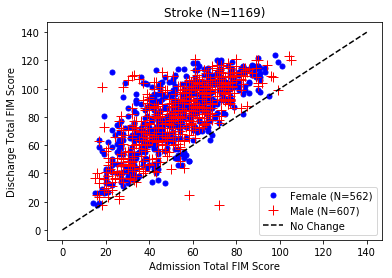

In [31]:
generate_ric_chart(data, "Stroke")

### 2. TBI (Traumatic brain injury)

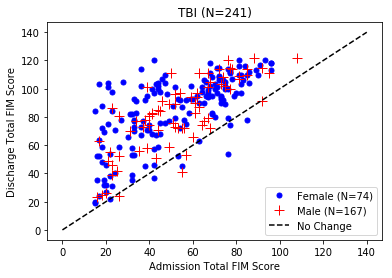

In [32]:
generate_ric_chart(data, "TBI")

### 3. NTBI (Non-traumatic brain injury)

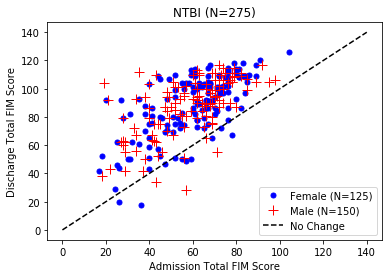

In [33]:
generate_ric_chart(data, "NTBI")